## Human-in-the-Loop - Approval Workflows
### Pause Execution for Human Approval
### Protect User with PII Guardrail
The guardrail node detects and blocks the following PII types:
- **SSN**: Social Security Numbers (123-45-6789)
- **Credit Card**: Card numbers (1234-5678-9012-3456)
- **Mobile Number**: Phone numbers (+1-234-567-8900, (234) 567-8900)
- **Email**: Email addresses (user@example.com)
- **URL/Link**: Web links (http://example.com, www.example.com)

Learning Objectives:
- Use interrupt() to pause execution
- Get human approval before actions
- Resume with Command API
- Protect user identities with PII

#### Real-World Use Cases:
1. **Financial Systems**: Approve large transactions
2. **Content Moderation**: Review AI content before publishing
3. **Customer Support**: Review sensitive responses
4. **DevOps**: Approve deployments

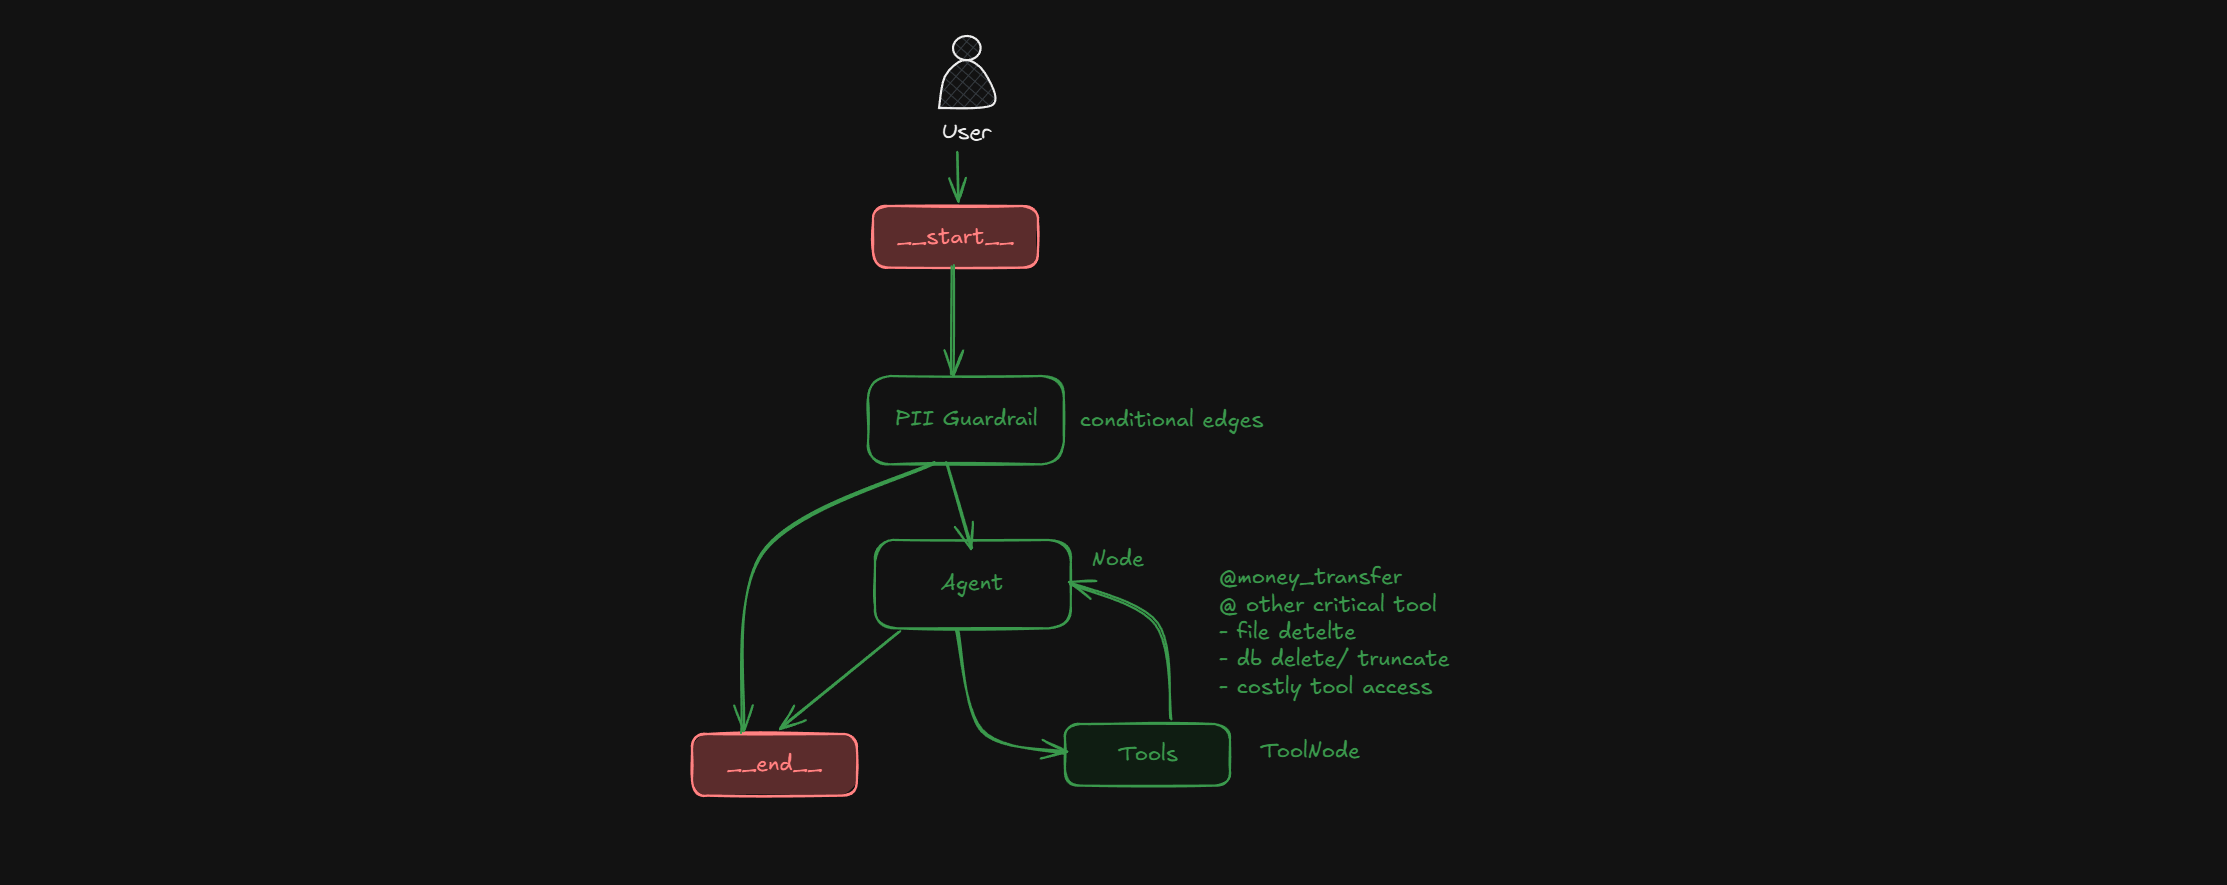

In [1]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver

from langgraph.types import Command, interrupt

from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import os
import re

# Configuration
BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3"
llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# =============================================================================
# State Definition
# =============================================================================
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]


In [4]:
# =============================================================================
# Transfer Money Tool
# =============================================================================
@tool
def transfer_money(amount:int, recipient:str):
    """
    Transfer money. Large transfers require approval.

    Args:
        amount: Amount in dollars
        recipient: Recipient name
    """

    # let's ask user approval if money is more than 1000
    if amount > 1000:
        approval = interrupt(
            {
                "type": "approval_required",
                "amount": amount,
                "recipient": recipient
            }
        )

        if approval.get("decision") != "approve":
            return "Transfer is cancelled!"

    return f"Transferred {amount} to {recipient}"

In [5]:
transfer_money.invoke({'amount': 100, 'recipient': 'Laxmi Kant'})

'Transferred 100 to Laxmi Kant'

In [6]:
# =============================================================================
# Guardrail Node - PII Detection
# =============================================================================
# PII Pattern Definitions
patterns = {
        "SSN": r'\b\d{3}-\d{2}-\d{4}\b',  # SSN: 123-45-6789
        "Credit Card": r'\b\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}\b',  # Credit Card: 1234-5678-9012-3456
        "Mobile Number": r'\b(\+?\d{1,3}[-.\s]?)?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}\b',  # Mobile: +1-234-567-8900
        "Email": r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',  # Email: user@example.com
        "URL/Link": r'https?://[^\s]+|www\.[^\s]+'  # URL: http://example.com or www.example.com
    }


def guardrail_node(state:AgentState):
    last_message = state['messages'][-1].content

    for pii_type, pattern in patterns.items():
        if re.search(pattern, last_message):
            return {
                "messages": [SystemMessage(f"Request Blocked: Contains {pii_type}. Please don't share sensitive personal information")]
            }
        
    return {"messages": []}




In [7]:
# =============================================================================
# Agent Node
# =============================================================================

def agent_node(state:AgentState):

    tools = [transfer_money]

    llm_with_tools = llm.bind_tools(tools)

    system_message = SystemMessage("You are a financial assistant. use transfer_money tool to transfer the money.")

    messages = [system_message] + state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[AGENT] Responding...")

    
    return {"messages": [response]}



In [8]:
## Conditional Edges
# guardrail, agent

def should_continue(state: AgentState):
    last = state['messages'][-1]
    
    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    else:
        return END
    
def guardrail_router(state:AgentState):
    last = state['messages'][-1]

    if isinstance(last, SystemMessage):
        last.pretty_print()
        return  END
    
    return 'agent'
    

In [9]:
# # DB Setup
import os

db_name = "db/checkpoints.db"

# if os.path.exists("db_name"):
#     os.removedirs(db_name)

import sqlite3

os.makedirs('db', exist_ok=True)



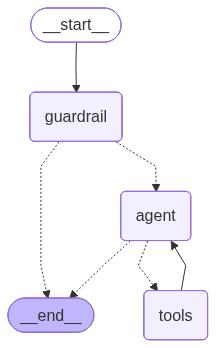

In [10]:
# =============================================================================
# Graph Construction
# =============================================================================

def create_agent():

    builder = StateGraph(AgentState)

    # add all nodes
    builder.add_node("guardrail", guardrail_node)
    builder.add_node("agent", agent_node)
    builder.add_node("tools", ToolNode([transfer_money]))

    # add egdes
    builder.add_edge(START, "guardrail")
    builder.add_conditional_edges("guardrail", guardrail_router, ['agent', END])
    builder.add_conditional_edges("agent", should_continue, ['tools', END])

    builder.add_edge("tools", "agent")

    # always get a fresh connection
    conn = sqlite3.connect(db_name, check_same_thread=False)
    checkpointer = SqliteSaver(conn)

    graph = builder.compile(checkpointer=checkpointer)

    return graph


agent = create_agent()
agent

In [11]:
# =============================================================================
# Demo 1: Small Transfer (No Interrupt)
# =============================================================================

config = {"configurable": {'thread_id': 'demo-2'}}

query = "Transfer 500 to laxmi Kant."
result = agent.invoke({
    "messages": [HumanMessage(query)]
}, config)
result

[AGENT] called Tool transfer_money with args {'amount': 500, 'recipient': 'laxmi kant'}
[AGENT] Responding...


{'messages': [HumanMessage(content='Transfer 500 to laxmi Kant.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-07T09:33:45.8367349Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2211869500, 'load_duration': 66210400, 'prompt_eval_count': 189, 'prompt_eval_duration': 45853100, 'eval_count': 154, 'eval_duration': 2073569800, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--13db5d34-cbae-4cf8-bf59-9b1b6582a053-0', tool_calls=[{'name': 'transfer_money', 'args': {'amount': 500, 'recipient': 'laxmi kant'}, 'id': '854ecd99-09c5-4808-bdfd-eeceb74dfe48', 'type': 'tool_call'}], usage_metadata={'input_tokens': 189, 'output_tokens': 154, 'total_tokens': 343}),
  ToolMessage(content='Transferred 500 to laxmi kant', name='transfer_money', tool_call_id='854ecd99-09c5-4808-bdfd-eeceb74dfe48'),
  AIMessage(content='The transfer of $500 to Laxmi Kant has been successfully p

In [24]:
# =============================================================================
# Demo 2: Large Transfer - Approval Required
# =============================================================================
query = "Transfer 5000 to laxmi Kant."
result = agent.invoke({
    "messages": [HumanMessage(query)]
}, config)
result


[AGENT] called Tool transfer_money with args {'amount': 5000, 'recipient': 'laxmi kant'}


{'messages': [HumanMessage(content='Transfer 500 to laxmi Kant.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-07T09:33:45.8367349Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2211869500, 'load_duration': 66210400, 'prompt_eval_count': 189, 'prompt_eval_duration': 45853100, 'eval_count': 154, 'eval_duration': 2073569800, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--13db5d34-cbae-4cf8-bf59-9b1b6582a053-0', tool_calls=[{'name': 'transfer_money', 'args': {'amount': 500, 'recipient': 'laxmi kant'}, 'id': '854ecd99-09c5-4808-bdfd-eeceb74dfe48', 'type': 'tool_call'}], usage_metadata={'input_tokens': 189, 'output_tokens': 154, 'total_tokens': 343}),
  ToolMessage(content='Transferred 500 to laxmi kant', name='transfer_money', tool_call_id='854ecd99-09c5-4808-bdfd-eeceb74dfe48'),
  AIMessage(content='The transfer of $500 to Laxmi Kant has been successfully p

In [25]:
if '__interrupt__' in result:

    interrupt_data = result['__interrupt__'][0]

    result = agent.invoke(
        Command(resume={'decision': input("do you approve or reject?")}),
        config
    )

    result['messages'][-1].pretty_print()

[AGENT] Responding...
================================== Ai Message ==================================

The transfer to Laxmi Kant was cancelled. Please check if there are any limits or additional requirements for large transfers. Let me know if you need further assistance!


In [ ]:
def chat(query, thread_id):
    config = {"configurable": {'thread_id': thread_id}}
    result = agent.invoke({
        "messages": [HumanMessage(query)]
    }, config)
    

    if '__interrupt__' in result:
        # use this data in front end design for approval workflow
        interrupt_data = result['__interrupt__'][0]

        result = agent.invoke(
            Command(resume={'decision': input("do you approve or reject?")}),
            config
        )

        
    result['messages'][-1].pretty_print()


In [27]:
query = "Transfer 5000 to laxmi Kant."
thread_id = "demo-3"

chat(query, thread_id)

[AGENT] called Tool transfer_money with args {'amount': 5000, 'recipient': 'laxmi Kant'}
[AGENT] Responding...
================================== Ai Message ==================================

The transfer of $5000 to **laxmi Kant** has been successfully processed. Let me know if you need further assistance!


In [28]:
thread_id = "demo-3"
query = "Transfer 5000 to udemy@kgptalkie.com."

chat(query, thread_id)

================================ System Message ================================

Request Blocked: Contains Email. Please don't share sensitive personal information
================================ System Message ================================

Request Blocked: Contains Email. Please don't share sensitive personal information


In [29]:
thread_id = "demo-3"
query = "Transfer 5000 to card 1234-5678-9012-3456."

chat(query, thread_id)

================================ System Message ================================

Request Blocked: Contains Credit Card. Please don't share sensitive personal information
================================ System Message ================================

Request Blocked: Contains Credit Card. Please don't share sensitive personal information


In [30]:
thread_id = "demo-3"
query = "Transfer 5000 to laxmi kant and send receipt to https://example.com/receipt."

chat(query, thread_id)

================================ System Message ================================

Request Blocked: Contains URL/Link. Please don't share sensitive personal information
================================ System Message ================================

Request Blocked: Contains URL/Link. Please don't share sensitive personal information


In [31]:
thread_id = "demo-3"
query = "Transfer 5000 to laxmi kant and send receipt to +1-234-567-8900."

chat(query, thread_id)

================================ System Message ================================

Request Blocked: Contains Mobile Number. Please don't share sensitive personal information
================================ System Message ================================

Request Blocked: Contains Mobile Number. Please don't share sensitive personal information
